### Anadarko FLuids QC - TX & NM

-------
**Job Code:** R&D

**Author:** Hasan Shojaei

**Analysis Type:** Fluids QC 

**Project Goals:**
* The main goals of this R&D project is to see how DNA signal changes as we we move away from the cuttings baseline well
* In this notebook we perform fluids QC

**Main Findings:**
* The usual shape of the Subsurface Signal vs. Biomass curve is observed
* 26% of fluids samples passed QC

**Date Last Modified:** 2019-04-03

**Data Through Group:** 107

-------

#### General Tools:

In [2]:
# Declaring path variables to make Basemap work in jupyter hub. Make sure that the conda environment path matches yours
import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2018.8/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2018.8/share/proj'

In [3]:
# General Tool Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import biota
import biota.plot as bpl
import seaborn as sns
import collections
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

from biota.database import (get_samples,
                            get_sample_data,
                            get_pg_connection,
                            get_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
from IPython.core.display import display, HTML
from pickle import dump, load

import lasio

# SQL Query imports
from sqlalchemy import create_engine, engine, inspect

from functools import partial

from ipyparallel import Client
from sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from skbio.stats.ordination import pcoa

from biota.util import assign_formations

%matplotlib inline

#### Data Query:

In [4]:
# Step 1: Establish link with database
con = get_pg_connection()

/home/jovyan/my-conda-envs/qiime2-2018.8/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
# Step 2: Define the tables and columns we want returned
# field columns we are interested in
field_columns = ['fieldsampleuuid', 'collectiondate', 'fieldsampletype', 'tvd', 'md',
       'collectionlocation', 'labid', 'jobcode']
field_columns = ', '.join(['field.{}'.format(e) for e in field_columns])

# well columns we are interested in
well_columns = ['welluuid', 'wellapi', 'wellname',
       'latitude', 'longitude', 'state', 'county', 'basin', 'play',
       'firstproductiondate', 'company', 'well_name_company']
well_columns = ', '.join(['well.{}'.format(e) for e in well_columns])

# sequence columns we are interested in
sequence_columns = ['sequencesampleuuid', 'sequencesampletype', 'barcodesequence', 'usage',
                    'sequencinggroup', 'necplate', 'extractionplate', 'pcryield', 'sequencingrunid']
sequence_columns = ', '.join(['sequence.{}'.format(e) for e in sequence_columns])

In [6]:
# Step 3: Format the query
query = """
SELECT {}, {}, {}
FROM sequence
INNER JOIN bridge
    ON sequence.sequencesampleuuid = bridge.sequencesampleuuid 
INNER JOIN field
    ON bridge.fieldsampleuuid = field.fieldsampleuuid
INNER JOIN well
    ON field.welluuid = well.welluuid
WHERE company ~ 'anadarko'
AND state IN ('texas','new.mexico')
""".format(field_columns, sequence_columns, well_columns)

In [7]:
# Step 4: Submit the query to the database to get the customer samples
customer_samples = pd.read_sql_query(query, con)

In [8]:
customer_samples.state.value_counts()

texas         14681
new.mexico       10
Name: state, dtype: int64

In [9]:
# Step 5: Tidy up and GROUP data
# tidy up
customer_samples.rename(columns={'collectionlocation': 'fieldsamplecollectionlocation',
                        'wellname': 'wellname'}, inplace=True)

# Import default groupings
from biota.database import DEFAULT_SQL_GROUPINGS
DEFAULT_SQL_GROUPINGS = {key.lower(): value for key, value in DEFAULT_SQL_GROUPINGS.items() \
                         if key in customer_samples.columns}

# group by sequencesampleuuid according to DEFAULT_GROUPINGS
customer_samples = customer_samples.groupby('sequencesampleuuid').agg(DEFAULT_SQL_GROUPINGS)
customer_samples.index = customer_samples.index.astype(str)

In [10]:
# Step 6: Get associated NECPlate names

# Format a parenthetical list of each item in the nec plates
nec_plates = customer_samples.necplate.unique().tolist()
nec_plates = [x for x in nec_plates if str(x) != 'nan']
in_nec_plate = (', '.join("'" + item + "'" for item in nec_plates))

# create query
nec_query = """
SELECT {}, {}
FROM sequence
INNER JOIN bridge
    ON sequence.sequencesampleuuid = bridge.sequencesampleuuid 
INNER JOIN field
    ON bridge.fieldsampleuuid = field.fieldsampleuuid
WHERE extractionplate IN ({})
AND sequencesampletype = 'negative.extraction.control'
""".format(field_columns, sequence_columns, in_nec_plate)

# get back nec dataframe
necs = pd.read_sql_query(nec_query, con)

from biota.database import DEFAULT_SQL_GROUPINGS
DEFAULT_SQL_GROUPINGS = {key.lower(): value for key, value in DEFAULT_SQL_GROUPINGS.items()
                         if key in necs.columns}
necs = necs.groupby('sequencesampleuuid').agg(DEFAULT_SQL_GROUPINGS)
necs.index = necs.index.astype(str)

In [11]:
# Step 7: Merge customer_samples and necs together into a single dataframe
samples = pd.concat([necs, customer_samples])

In [12]:
# Step 8: Get the data and features
data, features = get_data({'_id': {'$in': samples.index.tolist()}})

The filtering function dropped 0 samples and 66823 features


#### Fluids QC:

In [13]:
# get fluids samples only
fluids = samples.loc[samples.sequencesampletype.isin(['oil','oil.water','water'])].copy()

In [23]:
# save fluids dataframe to file
fluids.to_csv('../shared/APC_TXNM_fluids_04012019.txt', sep='\t')

In [14]:
# describes Collection Date and Sequencing data for Operational execution reasons
fluids['SequencedDate'] = pd.to_datetime(fluids.sequencingrunid.apply(lambda x: x[:8]))

In [15]:
# total number of DNA sequences per sample
fluids['SeqsPerSample'] = data.sum(axis=1)

In [16]:
customer_samples.fieldsampletype.value_counts()

produced.fluid    2264
wellcutting       1515
core                54
mud                  6
Name: fieldsampletype, dtype: int64

**Let's first create a map to see where fluid samples have been taken from in the field relative to cuttings**

In [17]:
customer_samples['color'] = customer_samples.fieldsampletype

In [18]:
customer_samples['marker'] = 'o'

In [19]:
customer_samples.color.replace({'wellcutting':'red',
                                'produced.fluid':'blue',
                                'core':'brown',
                                'mud':'white'}, inplace=True)

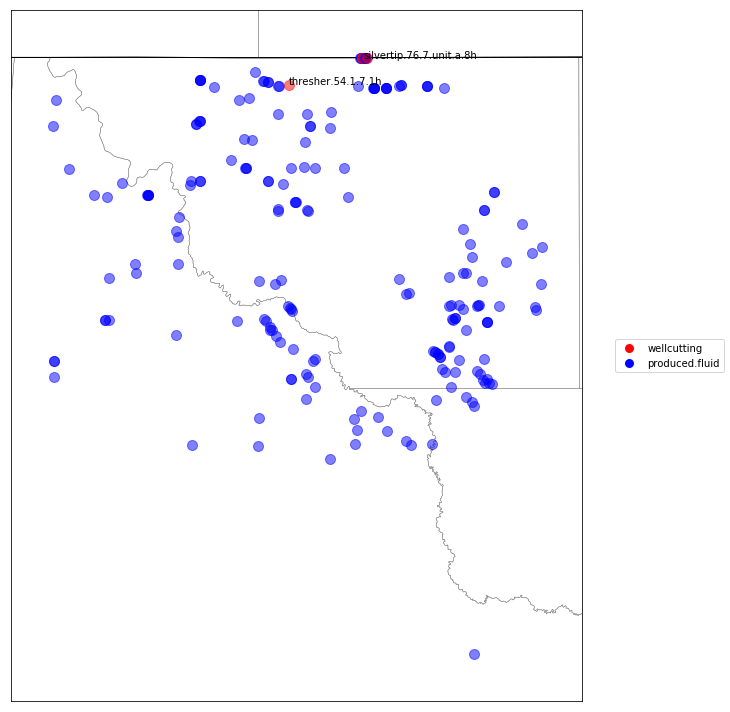

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

Wells = customer_samples.groupby('wellname').first()
Wells = Wells.loc[Wells.longitude < 0]
lat = list(Wells.latitude.astype(float))
long = list(Wells.longitude.astype(float))

buffer = 0.05

map = Basemap(llcrnrlon=min(Wells.longitude)-buffer, urcrnrlon=max(Wells.longitude)+buffer,
                  lon_0=0.5*(min(Wells.longitude)+max(Wells.longitude)),
                  llcrnrlat=min(Wells.latitude)-buffer, urcrnrlat=max(Wells.latitude)+buffer,
                  lat_0=0.5*(min(Wells.latitude)+max(Wells.latitude)),
                  projection='tmerc')
# add county boundaries
map.readshapefile('/home/jovyan/my-conda-envs/qiime2-2018.8/share/basemap/cb_2017_us_county_500k',
                  'counties',drawbounds=True,
                  linewidth=0.45,color='gray')
# add state boundaries
map.readshapefile('/home/jovyan/my-conda-envs/qiime2-2018.8/share/basemap/st99_d00','states',
                  drawbounds=True,linewidth=1,color='black')

for i, r in Wells.iterrows():
    x, y = map(r.longitude, r.latitude)
    map.plot(x, y, marker=r.marker, c=r.color, ms=10, alpha=0.5)
    if i in ['silvertip.76.7.unit.a.8h', 'thresher.54.1.7.1h']:
        ax.annotate(i, (x, y))
    
# map.drawmapscale(min(long)+0.15, min(lat), 0.5*(min(long)+max(long)), 0.5*(min(lat)+max(lat)), 
#                  length=10, barstyle='simple', units='mi')

F0 = Line2D([],[], marker='o', color='w', markerfacecolor='red', label='wellcutting', markersize=10)
F1 = Line2D([],[], marker='o', color='w', markerfacecolor='blue', label='produced.fluid', markersize=10)
ax.legend(handles=[F0,F1],loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.tight_layout()
fig.savefig('../images/APC_cuttings_vs_fluids_map.png', dpi=300, bbox_inches='tight')

In [22]:
# Run SourceTracker or just load saved results
try:
    qc_mps = load(open('../pickles/fluids_vs_nec_04042019.pickle', 'rb'))

# If the above pickle file is not found, we'll run SourceTracker    
except:
    # set source tracker parameters
    st_params = {'alpha1' : 0.01,
                 'alpha2' : 0.01, 
                 'beta' : 10, 
                 'burnin' : 50,
                 'delay' : 10, 
                 'restarts' : 2, 
                 'draws_per_restart' : 5,
                 'cluster': Client()}
    
    qc_mps = []
    for necplate, sink_samples in fluids.groupby('necplate'):
        source_samples = necs.loc[necs.extractionplate == necplate].copy()
        
        if len(source_samples)!=0:

            data_sources = data.loc[source_samples.index].copy().dropna()
            data_sources = rarefy(data_sources, 5000)
            data_sources = data_sources.groupby(necs.sequencesampletype).sum()

            data_sinks = data.loc[sink_samples.index].copy().dropna()
            data_sinks = rarefy(data_sinks, 5000)

            qc_mp, _, qc_table = gibbs(data_sources, data_sinks, **st_params)
            qc_mps.append(qc_mp)
    
    qc_mps = pd.concat(qc_mps)
    dump(qc_mps, open('../pickles/fluids_vs_nec_04042019.pickle', 'wb'))

In [23]:
qc_mps['PCRYield'] = fluids.pcryield
fluids['Unknown'] = qc_mps.Unknown
qc_mps['wellname'] = fluids.wellname

''

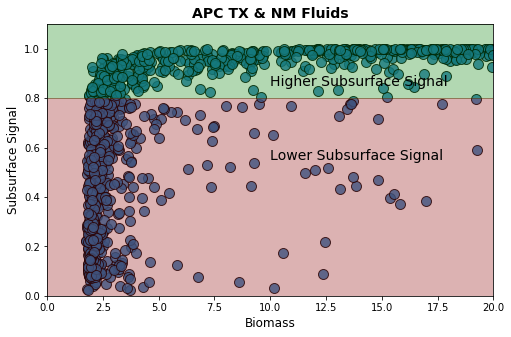

In [28]:
fig, ax = plt.subplots(1, figsize=(8, 5))

# Plot a scatter with x=PCRYield, and y=Unknown using the mp dataframe
ax.scatter(qc_mps.PCRYield, qc_mps.Unknown, s=100, edgecolor='k', alpha=0.8)

# Relabel x,y axis and set pretty limits
ax.set_ylabel('Subsurface Signal', size=12)
ax.set_xlabel('Biomass', size=12)
ax.set_title('APC TX & NM Fluids', size=14, weight='bold')
ax.set_xlim(0, 20)
ax.set_ylim(0, 1.1)

# Create patches that capture the 0-80% y-axis, and 80-100% y-axis
# to denote higher and lower subsurface signal sections
highsignal = Rectangle((0, 0.8), 25, 0.3, alpha=0.3, color='green')
lowsignal = Rectangle((0, 0.0), 25, 0.8, alpha=0.3, color='darkred')

# Add patches and annotate
ax.add_patch(highsignal)
ax.annotate('Higher Subsurface Signal', (10, 0.85), color='black', size=14)
ax.add_patch(lowsignal)
ax.annotate('Lower Subsurface Signal', (10, 0.55), color='black', size=14)

# Save high resolution image - easier to copy over into presentations
fig.savefig('../images/APC_TXNM_fluids_qc_0404201.png', dpi=300, bbox_inches='tight')
,

##### Thoughts:
- The usual shape of the Subsurface Signal vs. Biomass curve is observed 

#### Cuttings QC Statistics

In [29]:
fluids.loc[(fluids.SeqsPerSample >= 5000) &
             (fluids.Unknown >= 0.80), 'QCPass'] = 1

In [30]:
qc_fluids = fluids.loc[fluids.QCPass == 1].copy()

In [31]:
qc_fluids.to_csv('../shared/APC_TXNM_fluids_passing_qc_04042019.txt', sep='\t')

In [35]:
# total number of fluid samples
fluids.shape[0]

2264

In [36]:
# samples having at least 5000 sequences
fluids[fluids.SeqsPerSample >= 5000].shape[0]

2216

In [37]:
fluids.QCPass.sum()

587.0

In [39]:
# percentage of total fluid samples passing QC
round(100*qc_fluids.shape[0] / fluids.shape[0], 2)

25.93

##### Thoughts:
- 26% of fluids samples passed QC